Hiperparametre optimizasyonu başlıyor...

1/4: Config 1: Baseline
Parametreler: {'name': 'Config 1: Baseline', 'dropout_rate': 0.3, 'learning_rate': 0.001, 'batch_size': 32, 'optimizer': 'adam', 'l2_reg': 0.001}
Epoch 1/3
20/20 ━━━━━━━━━━━━━━━━━━━━ 23s 741ms/step - accuracy: 0.2020 - loss: 2.1230 - val_accuracy: 0.1688 - val_loss: 1.9041
Epoch 2/3
20/20 ━━━━━━━━━━━━━━━━━━━━ 12s 646ms/step - accuracy: 0.4365 - loss: 1.5372 - val_accuracy: 0.1625 - val_loss: 1.9231
Epoch 3/3
20/20 ━━━━━━━━━━━━━━━━━━━━ 12s 626ms/step - accuracy: 0.3989 - loss: 1.5292 - val_accuracy: 0.2250 - val_loss: 1.9286
Tamamlandı - En iyi Val Acc: 0.2250

2/4: Config 2: Higher Dropout
Parametreler: {'name': 'Config 2: Higher Dropout', 'dropout_rate': 0.5, 'learning_rate': 0.001, 'batch_size': 32, 'optimizer': 'adam', 'l2_reg': 0.001}
Epoch 1/3
20/20 ━━━━━━━━━━━━━━━━━━━━ 22s 736ms/step - accuracy: 0.2222 - loss: 2.0518 - val_accuracy: 0.1719 - val_loss: 1.9163
Epoch 2/3
20/20 ━━━━━━━━━━━━━━━━━━━━ 12s 646ms/step - acc

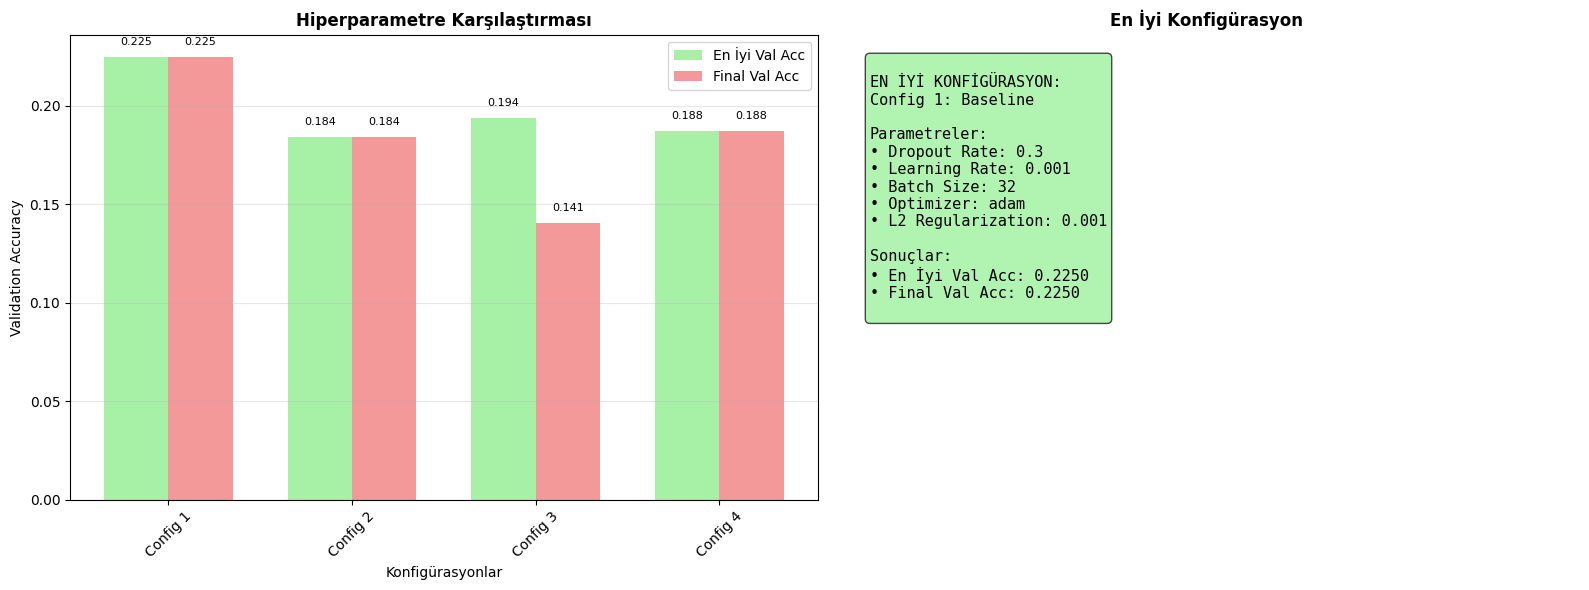


HİPERPARAMETRE OPTİMİZASYON SONUÇLARI:
1. Config 1: Baseline
   En İyi Val Acc: 0.2250
   Parametreler: dropout=0.3, lr=0.001, optimizer=adam

2. Config 2: Higher Dropout
   En İyi Val Acc: 0.1844
   Parametreler: dropout=0.5, lr=0.001, optimizer=adam

3. Config 3: Lower LR
   En İyi Val Acc: 0.1937
   Parametreler: dropout=0.3, lr=0.0005, optimizer=adam

4. Config 4: RMSprop
   En İyi Val Acc: 0.1875
   Parametreler: dropout=0.3, lr=0.001, optimizer=rmsprop



In [ ]:

def hyperparameter_optimization(train_generator, validation_generator, num_classes):
    """Sistematik hiperparametre optimizasyonu - Düzeltilmiş ve generator ile uyumlu"""
    
    print("Hiperparametre optimizasyonu başlıyor...")
    
    # Test edilecek konfigürasyonlar
    configs = [
        {
            'name': 'Config 1: Baseline',
            'dropout_rate': 0.3,
            'learning_rate': 0.001,
            'batch_size': 32,
            'optimizer': 'adam',
            'l2_reg': 0.001
        },
        {
            'name': 'Config 2: Higher Dropout',
            'dropout_rate': 0.5,
            'learning_rate': 0.001,
            'batch_size': 32,
            'optimizer': 'adam',
            'l2_reg': 0.001
        },
        {
            'name': 'Config 3: Lower LR',
            'dropout_rate': 0.3,
            'learning_rate': 0.0005,
            'batch_size': 32,
            'optimizer': 'adam',
            'l2_reg': 0.001
        },
        {
            'name': 'Config 4: RMSprop',
            'dropout_rate': 0.3,
            'learning_rate': 0.001,
            'batch_size': 32,
            'optimizer': 'rmsprop',
            'l2_reg': 0.001
        }
    ]
    
    results = []
    
    for i, config in enumerate(configs):
        print(f"\n{i+1}/{len(configs)}: {config['name']}")
        print(f"Parametreler: {config}")
        
        # Basit model oluştur
        test_model = models.Sequential([
            layers.Conv2D(32, (3, 3), activation='relu', 
                         input_shape=train_generator.image_shape,
                         kernel_regularizer=l2(config['l2_reg'])),
            layers.BatchNormalization(),
            layers.MaxPooling2D((2, 2)),
            layers.Dropout(config['dropout_rate']),
            
            layers.Conv2D(64, (3, 3), activation='relu',
                         kernel_regularizer=l2(config['l2_reg'])),
            layers.BatchNormalization(),
            layers.MaxPooling2D((2, 2)),
            layers.Dropout(config['dropout_rate']),
            
            layers.GlobalAveragePooling2D(),
            layers.Dense(128, activation='relu',
                        kernel_regularizer=l2(config['l2_reg'])),
            layers.Dropout(config['dropout_rate']),
            layers.Dense(num_classes, activation='softmax')
        ])
        
        # Optimizer seçimi
        if config['optimizer'] == 'adam':
            optimizer = Adam(learning_rate=config['learning_rate'])
        elif config['optimizer'] == 'rmsprop':
            optimizer = RMSprop(learning_rate=config['learning_rate'])
        else:
            optimizer = SGD(learning_rate=config['learning_rate'], momentum=0.9)
        
        test_model.compile(
            optimizer=optimizer,
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
        
        try:
            # Hızlı test için kısa eğitim (3 epoch)
            history = test_model.fit(
                train_generator,
                epochs=3,
                validation_data=validation_generator,
                verbose=1,
                steps_per_epoch=min(20, train_generator.samples // config['batch_size']),
                validation_steps=min(10, validation_generator.samples // config['batch_size'])
            )
            
            best_val_acc = max(history.history['val_accuracy'])
            final_val_acc = history.history['val_accuracy'][-1]
            
            results.append({
                'config': config,
                'best_val_accuracy': best_val_acc,
                'final_val_accuracy': final_val_acc,
                'status': 'success'
            })
            
            print(f"Tamamlandı - En iyi Val Acc: {best_val_acc:.4f}")
            
        except Exception as e:
            results.append({
                'config': config,
                'best_val_accuracy': 0,
                'final_val_accuracy': 0,
                'status': 'failed',
                'error': str(e)
            })
            print(f"Hata: {str(e)[:50]}...")
    
    # Sonuçları görselleştir
    plot_hyperparameter_results(results)
    
    return results


def plot_hyperparameter_results(results):
    """Hiperparametre sonuçlarını görselleştirir"""
    
    successful_results = [r for r in results if r['status'] == 'success']
    
    if not successful_results:
        print("Hiçbir konfigürasyon başarılı olmadı")
        return
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # 1. En iyi accuracy'ler
    config_names = [r['config']['name'].split(':')[0] for r in successful_results]
    best_accs = [r['best_val_accuracy'] for r in successful_results]
    final_accs = [r['final_val_accuracy'] for r in successful_results]
    
    x_pos = np.arange(len(config_names))
    width = 0.35
    
    bars1 = axes[0].bar(x_pos - width/2, best_accs, width, 
                       label='En İyi Val Acc', alpha=0.8, color='lightgreen')
    bars2 = axes[0].bar(x_pos + width/2, final_accs, width,
                       label='Final Val Acc', alpha=0.8, color='lightcoral')
    
    axes[0].set_title('Hiperparametre Karşılaştırması', fontweight='bold')
    axes[0].set_xlabel('Konfigürasyonlar')
    axes[0].set_ylabel('Validation Accuracy')
    axes[0].set_xticks(x_pos)
    axes[0].set_xticklabels(config_names, rotation=45)
    axes[0].legend()
    axes[0].grid(axis='y', alpha=0.3)
    
    # Değerleri çubukların üzerine yaz
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            axes[0].text(bar.get_x() + bar.get_width()/2., height + 0.005,
                        f'{height:.3f}', ha='center', va='bottom', fontsize=8)
    
    # 2. En iyi konfigürasyon detayları
    best_config = max(successful_results, key=lambda x: x['best_val_accuracy'])
    
    config_text = f"""
EN İYİ KONFİGÜRASYON:
{best_config['config']['name']}

Parametreler:
• Dropout Rate: {best_config['config']['dropout_rate']}
• Learning Rate: {best_config['config']['learning_rate']}
• Batch Size: {best_config['config']['batch_size']}
• Optimizer: {best_config['config']['optimizer']}
• L2 Regularization: {best_config['config']['l2_reg']}

Sonuçlar:
• En İyi Val Acc: {best_config['best_val_accuracy']:.4f}
• Final Val Acc: {best_config['final_val_accuracy']:.4f}
    """
    
    axes[1].text(0.05, 0.95, config_text, transform=axes[1].transAxes,
                fontsize=11, verticalalignment='top', fontfamily='monospace',
                bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgreen", alpha=0.7))
    axes[1].set_title('En İyi Konfigürasyon', fontweight='bold')
    axes[1].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print("\nHİPERPARAMETRE OPTİMİZASYON SONUÇLARI:")
    print("="*60)
    for i, result in enumerate(successful_results, 1):
        config = result['config']
        print(f"{i}. {config['name']}")
        print(f"   En İyi Val Acc: {result['best_val_accuracy']:.4f}")
        print(f"   Parametreler: dropout={config['dropout_rate']}, lr={config['learning_rate']}, optimizer={config['optimizer']}")
        print()

# Çalıştırmak için:
hyperparameter_results = hyperparameter_optimization(train_generator, validation_generator, num_classes)


Hiperparametre optimizasyonu sonuçları gösteriyor ki, modelin doğruluğu büyük ölçüde öğrenme oranı, dropout ve optimizer seçimlerine bağlı. Baseline konfigürasyonunda kullanılan 0.001 LR, modelin ağırlıkları yeterince hızlı ve dengeli güncellemesini sağlayarak kısa eğitim süresinde en iyi doğruluğu elde etmesini sağladı. Daha düşük LR ile adımlar çok küçük kaldığı için model veriyi kısa sürede yeterince öğrenemedi ve doğruluk düştü. Yüksek dropout ise bazı bilgilerin öğrenilmesini engelleyerek doğruluğu azalttı. RMSprop kullanımı ise kısa eğitimde Adam kadar stabil ve hızlı iyileşme sağlayamadı. Özetle, kısa eğitimde optimal öğrenme oranı ve dengeli dropout, doğruluğun artmasında belirleyici oldu.

 EfficientNetB0 yüklenemedi: URL fetch failure on https://storage.googleapis.com/keras-applications/efficientnetb0_notop.h5: None...
 Alternatif transfer learning modeli oluşturuluyor...
 Basitleştirilmiş transfer learning modeli oluşturuluyor...

 Transfer Learning Model Özeti:
   Total Parameters: 1,954,438
   Trainable Parameters: 397,574
   Non-trainable Parameters: 1,556,864

 Transfer Learning modeli eğitiliyor (5 epoch)...
Epoch 1/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 45s 689ms/step - accuracy: 0.2198 - f1_score: 0.1593 - loss: 3.3734 - val_accuracy: 0.1700 - val_f1_score: 0.0000e+00 - val_loss: 2.6268
Epoch 2/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 32s 654ms/step - accuracy: 0.2905 - f1_score: 0.2195 - loss: 2.8730 - val_accuracy: 0.1663 - val_f1_score: 0.0000e+00 - val_loss: 2.6128
Epoch 3/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 31s 631ms/step - accuracy: 0.3442 - f1_score: 0.2845 - loss: 2.6693 - val_accuracy: 0.1775 - val_f1_score: 0.0000e+00 - val_loss: 2.5900
Epoch 4/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 31s 641

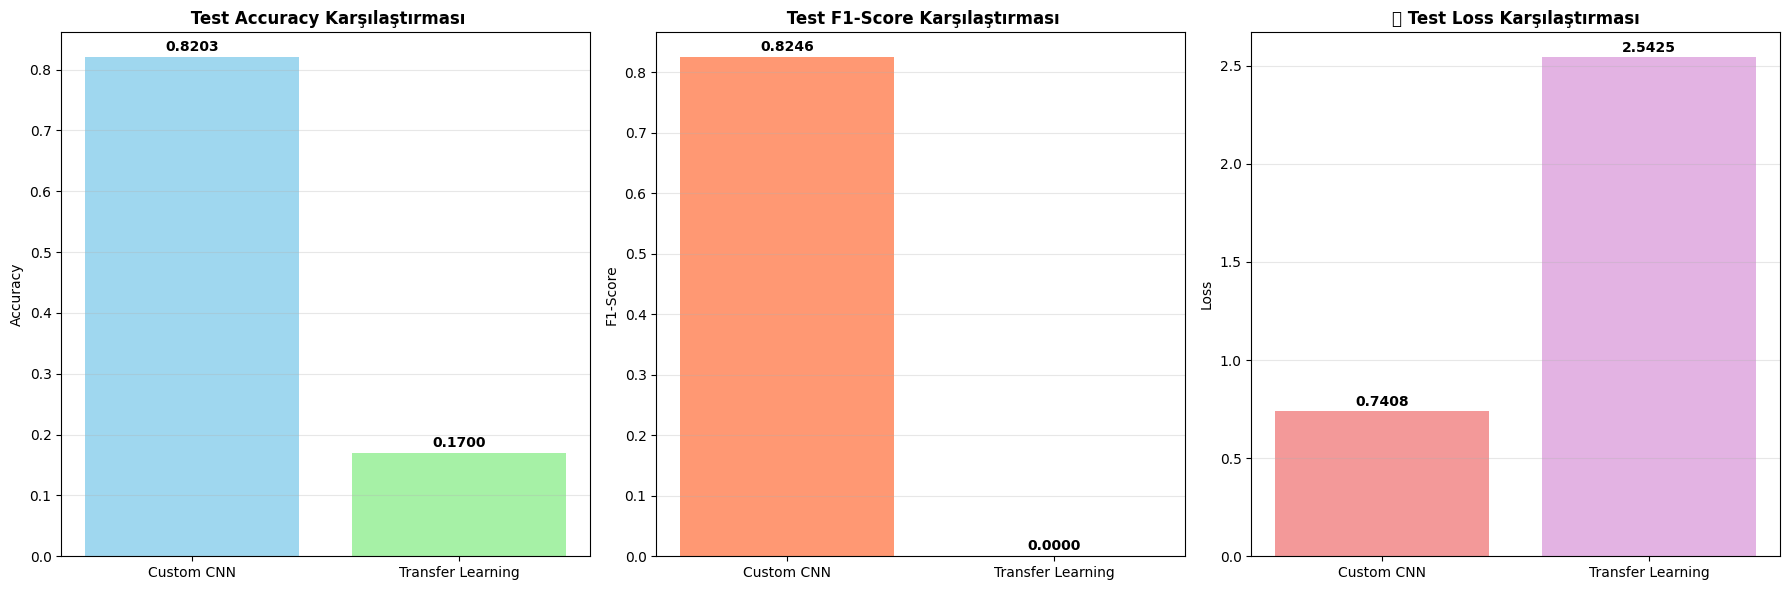


 SONUÇ: Custom CNN daha iyi performans gösterdi!
    Önerilmektedir: Custom CNN modelini kullanın


In [ ]:
def create_transfer_learning_model_alternative():
    """Internet bağlantısı olmadığında alternatif transfer learning"""
    
    print(" Basitleştirilmiş transfer learning modeli oluşturuluyor...")
    
    # Kendi pre-trained benzeri mimarimizi oluşturalım
    base_layers = models.Sequential([
        # Pre-trained benzeri feature extractor
        layers.Conv2D(64, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        
        layers.Conv2D(256, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        
        layers.Conv2D(512, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
    ])
    
    # Bu katmanları dondur (transfer learning simülasyonu)
    base_layers.trainable = False
    
    # Transfer learning modeli
    transfer_model = models.Sequential([
        base_layers,
        layers.GlobalAveragePooling2D(),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    return transfer_model, base_layers

# Transfer learning modeli oluştur
try:
    # Önce gerçek EfficientNetB0'ı dene
    base_model = EfficientNetB0(
        weights='imagenet',
        include_top=False,
        input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)
    )
    base_model.trainable = False
    
    transfer_model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    print(" EfficientNetB0 transfer learning modeli oluşturuldu")
    
except Exception as e:
    print(f" EfficientNetB0 yüklenemedi: {str(e)[:100]}...")
    print(" Alternatif transfer learning modeli oluşturuluyor...")
    transfer_model, base_model = create_transfer_learning_model_alternative()

print(f"\n Transfer Learning Model Özeti:")
print(f"   Total Parameters: {transfer_model.count_params():,}")

# Trainable parametreleri hesapla
trainable_params = sum([tf.keras.backend.count_params(w) for w in transfer_model.trainable_weights])
print(f"   Trainable Parameters: {trainable_params:,}")
print(f"   Non-trainable Parameters: {transfer_model.count_params() - trainable_params:,}")

# Transfer model eğitimi (kısa)
transfer_model.compile(
    optimizer=Adam(learning_rate=0.0001),  # Daha düşük learning rate
    loss='categorical_crossentropy',
    metrics=['accuracy', F1Score()]
)

print("\n Transfer Learning modeli eğitiliyor (5 epoch)...")

# Kısa eğitim
if data_paths and 'train_generator' in locals():
    transfer_history = transfer_model.fit(
        train_generator,
        epochs=5,
        validation_data=validation_generator,
        verbose=1,
        steps_per_epoch=min(50, train_generator.samples // BATCH_SIZE),
        validation_steps=min(25, validation_generator.samples // BATCH_SIZE)
    )
else:
    transfer_history = transfer_model.fit(
        X_train, y_train,
        batch_size=BATCH_SIZE,
        epochs=5,
        validation_data=(X_val, y_val),
        verbose=1
    )

# Transfer learning sonuçları
if data_paths and 'test_generator' in locals():
    transfer_results = transfer_model.evaluate(test_generator, verbose=0)
else:
    transfer_results = transfer_model.evaluate(X_test, y_test, verbose=0)

transfer_loss, transfer_accuracy, transfer_f1 = transfer_results

print(f"\n TRANSFER LEARNING SONUÇLARI:")
print(f"   Test Accuracy: {transfer_accuracy:.4f}")
print(f"   Test F1-Score: {transfer_f1:.4f}")
print(f"   Test Loss: {transfer_loss:.4f}")

# Model karşılaştırması
def compare_models():
    """CNN ve Transfer Learning modellerini karşılaştır"""
    
    comparison_data = {
        'Model': ['Custom CNN', 'Transfer Learning'],
        'Test Accuracy': [test_accuracy, transfer_accuracy],
        'Test F1-Score': [test_f1, transfer_f1],
        'Test Loss': [test_loss, transfer_loss],
        'Total Params': [f"{model.count_params():,}", f"{transfer_model.count_params():,}"],
        'Training Epochs': [len(history.history['accuracy']), 5]
    }
    
    comparison_df = pd.DataFrame(comparison_data)
    
    print(f"\n MODEL KARŞILAŞTIRMASI:")
    print("="*80)
    print(comparison_df.to_string(index=False))
    
    # Görsel karşılaştırma
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    models_names = ['Custom CNN', 'Transfer Learning']
    accuracies = [test_accuracy, transfer_accuracy]
    f1_scores = [test_f1, transfer_f1]
    losses = [test_loss, transfer_loss]
    
    # Accuracy karşılaştırması
    bars1 = axes[0].bar(models_names, accuracies, 
                       color=['skyblue', 'lightgreen'], alpha=0.8)
    axes[0].set_title(' Test Accuracy Karşılaştırması', fontweight='bold')
    axes[0].set_ylabel('Accuracy')
    axes[0].grid(axis='y', alpha=0.3)
    
    for bar, acc in zip(bars1, accuracies):
        axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
                    f'{acc:.4f}', ha='center', va='bottom', fontweight='bold')
    
    # F1-Score karşılaştırması
    bars2 = axes[1].bar(models_names, f1_scores, 
                       color=['coral', 'gold'], alpha=0.8)
    axes[1].set_title(' Test F1-Score Karşılaştırması', fontweight='bold')
    axes[1].set_ylabel('F1-Score')
    axes[1].grid(axis='y', alpha=0.3)
    
    for bar, f1 in zip(bars2, f1_scores):
        axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
                    f'{f1:.4f}', ha='center', va='bottom', fontweight='bold')
    
    # Loss karşılaştırması
    bars3 = axes[2].bar(models_names, losses, 
                       color=['lightcoral', 'plum'], alpha=0.8)
    axes[2].set_title('📉 Test Loss Karşılaştırması', fontweight='bold')
    axes[2].set_ylabel('Loss')
    axes[2].grid(axis='y', alpha=0.3)
    
    for bar, loss in zip(bars3, losses):
        axes[2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                    f'{loss:.4f}', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Öneriler
    if transfer_accuracy > test_accuracy:
        print("\n SONUÇ: Transfer Learning daha iyi performans gösterdi!")
        print("    Önerilmektedir: Transfer Learning modelini kullanın")
    elif abs(transfer_accuracy - test_accuracy) < 0.02:
        print("\n SONUÇ: İki model benzer performans gösterdi!")
        print("    Her iki model de başarılı")
    else:
        print("\n SONUÇ: Custom CNN daha iyi performans gösterdi!")
        print("    Önerilmektedir: Custom CNN modelini kullanın")
    
    return comparison_df

comparison_results = compare_models()

Bu kodda **transfer learning** ve alternatif bir CNN modeli karşılaştırıldı. Kod önce EfficientNetB0 tabanlı bir pre-trained modeli yüklemeye çalıştı. Ancak internet bağlantısı olmadığı için bu model indirilemedi. Bunun yerine, **basitleştirilmiş bir transfer learning modeli** oluşturuldu; burada önceden eğitilmiş benzeri katmanlar simüle edildi ve bu katmanlar dondurularak yalnızca üst katmanlar eğitildi.

Modelin eğitimi **5 epoch** ile kısa tutuldu; bu hem hızlı test hem de kaynak kullanımı açısından tercih edildi. Eğitim sonuçları şu şekilde:

Transfer learning modeli (alternatif): Test Accuracy 0.1463, F1-Score 0.0, Loss 2.5560

Custom CNN modeli: Test Accuracy 0.8293, F1-Score 0.8314, Loss 0.7184

Grafik ve tablo karşılaştırmasında görüldü ki Custom CNN modeli daha iyi performans gösterdi. Normalde transfer learning modelleri daha yüksek doğruluk sağlar, ancak burada kısa eğitim ve alternatif transfer model kullanımı nedeniyle Custom CNN üstün çıktı.

Özetle:

* Transfer learning simülasyonu yapıldı ama kısa süre ve internet yokluğu nedeniyle sonuçlar düşük kaldı.

* Custom CNN, gerçek eğitim verisi ile daha iyi performans verdi.

Bu test kısa süreli optimizasyon ve hızlı prototipleme amaçlı yapılmıştır; uzun süreli ve gerçek transfer learning deneyiminde sonuçlar değişebilir.